# Análisis de datos exploratorio

## Cargar datos

In [4]:
import pandas as pd
import numpy as np
import os

In [5]:
def load_data():
    !curl -L "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/945z9xkc8d-1.zip" -o data.zip 
    !unzip "data.zip" && unzip "Fake News Dataset.zip"
    !del -r *.zip 
    
    main_directory = os.path.join(os.getcwd(),"Fake News Dataset")
    subdirectories = [x[0] for x in os.walk(main_directory)][1:]
    print(main_directory)
    dataframes = []
    # Itera a través de los subdirectorios y archivos train.csv
    for subdirectory in subdirectories:
        file_path = os.path.join(subdirectory, "train.csv")
        
        # Verifica si el archivo train.csv existe en el subdirectorio
        if os.path.exists(file_path):
            data = pd.read_csv(file_path)
            dataframes.append(data)

    # Combina los DataFrames en uno solo
    combined_data = pd.concat(dataframes, ignore_index=True)

    # Guarda el DataFrame combinado en un archivo train_combined.csv
    combined_data.to_csv("dataset.csv", index=False)
    print("Archivos train.csv combinados con éxito en train_combined.csv")

In [ ]:
try:
    df = pd.read_csv("dataset.csv",sep=";")
except:
    print("Downloading dataset .....")
    load_data()
    df = pd.read_csv("dataset.csv",sep=";")
    # !curl -L "https://huggingface.co/datasets/GonzaloA/fake_news/resolve/refs%2Fconvert%2Fparquet/default/train/0000.parquet" -o 0.parquet 

## Inspeccionar datos

In [7]:
df.head(5)

,text,label
0,dark agenda behind globalism open border altma...,0
1,america poor still get shaft sami jamil jadall...,0
2,number accuser grow former miss finland accuse...,0
3,heroic prego advertisement replaces refresh we...,0
4,russia syria debbie reynolds thursday even bri...,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61590 entries, 0 to 61589
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    61590 non-null  object
 1   label   61590 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 962.5+ KB


# Visualizacion del Dataset

## Dataset Balanceado

d:\Codes\IA-Project\.env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Codes\IA-Project\.env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Codes\IA-Project\.env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Codes\IA-Project\.env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

Text(-12.430555555555555, 0.5, 'Conteo')

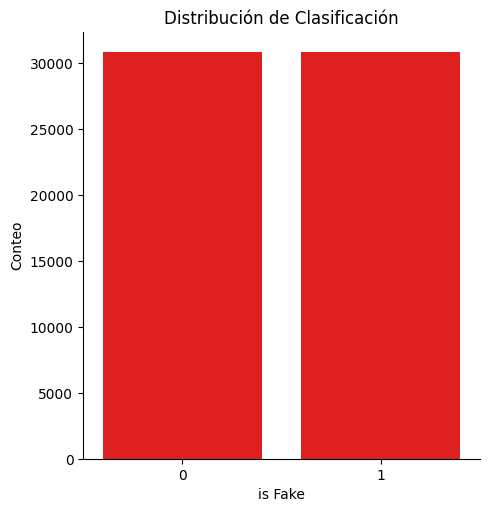

In [9]:
## Librerias para graficación
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizamos si la data esta balanceada
sns.catplot(x="label", kind="count", color="r", data=df)
plt.title("Distribución de Clasificación")
plt.xlabel("is Fake")
plt.ylabel("Conteo")

## Word Cloud de los titulares de las *Fake News*

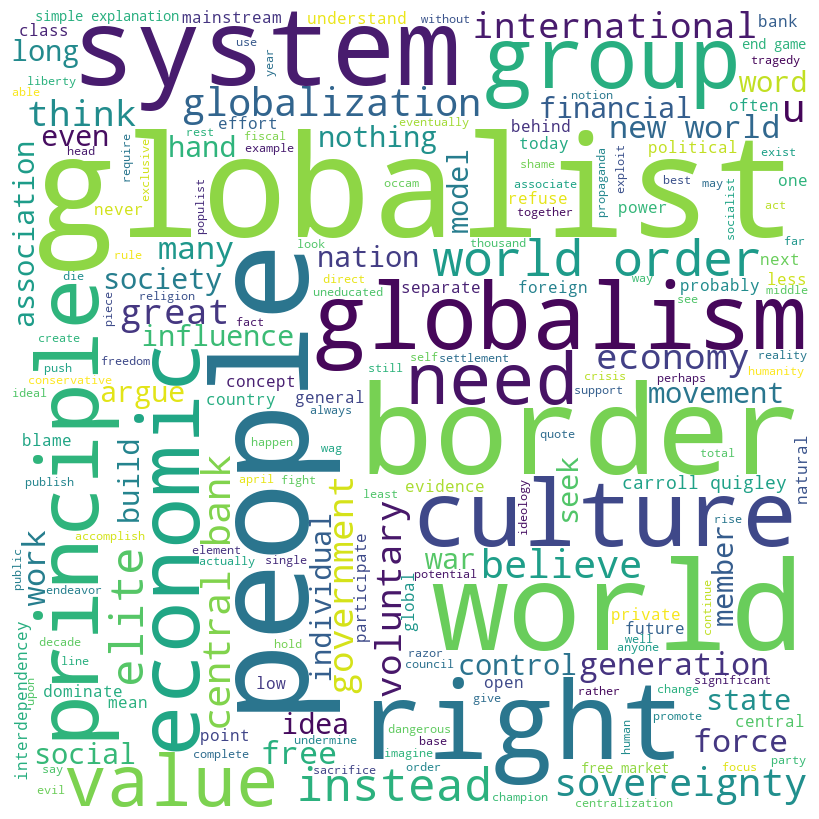

In [11]:
# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS

comment_words = ""
stopwords = set(STOPWORDS)

# Recorrer el dataframe
for val in df["text"][0:1]:
    # Castear cada palabra a string
    val = str(val)

    # Separamos por palabra
    tokens = val.split()

    # Pasamos a minusculas
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens) + " "

wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",
    stopwords=stopwords,
    min_font_size=10,
).generate(comment_words)

# Generamos el plot
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Pre-Procesado de los datos para NLP

In [12]:
df["features"] = df["text"]

## 2. Tokenization

In [13]:

# importamos word_tokenize desde nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist


In [14]:
# Pasar el texto de la cadena a la palabra tokenize para romper las oraciones
df["features"] = df["features"].apply(lambda x: word_tokenize(x))

In [ ]:
df["features"].head()

In [16]:
print(FreqDist(df["features"][:1].to_list()[0]).most_common)

<bound method Counter.most_common of FreqDist({'world': 24, 'people': 14, 'globalists': 13, 'border': 12, 'right': 9, 'central': 9, 'system': 9, 'bank': 9, 'order': 9, 'globalism': 8, ...})>


## 3. Lemmatization

In [17]:
import nltk
lemmer = nltk.stem.WordNetLemmatizer()
 
df["features"] = df["features"].apply(lambda x: [lemmer.lemmatize(y) for y in x])

## 4. StopWords

In [18]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pms_l\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
# debemos indicar que la oracion se encuentra en ingles
a = set(stopwords.words("english"))

# convertimos el texto a minusculas
df["features"] = df["features"].apply(lambda x: [y.lower() for y in x])
# Eliminamos las stop words del dataset
df["features"] = df["features"].apply(lambda x: [y for y in x if y not in a])

## Creacion de la representacion del texto (Word2Vec, Keras Embedding, BOW)

In [20]:
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [21]:
max_words = 10000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df["features"])

X_sequences = tokenizer.texts_to_sequences(
    df["features"]
)  # Convertir texto a secuencia de números

X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length)

X_train, X_test, y_train, y_test = train_test_split(
        X_padded, df["label"], test_size=0.2, random_state=42
)

# Modelating

## Redes Neuronales 

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Flatten 
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras.regularizers import l2

In [23]:
# Construir y entrenar la red neuronal
model = Sequential()

# Hiperparámetro de regularización L2
l2_lambda = 0.01  # Ajusta este valor según tus necesidades

embedding_dim = 100
max_words = 10000
max_sequence_length = 100

# Capa de Embedding con regularización L2
model.add(
    Embedding(
        input_dim=max_words,
        output_dim=embedding_dim,
        input_length=max_sequence_length,
        embeddings_regularizer=l2(l2_lambda),
    )
)

# Capa LSTM
model.add(LSTM(32))

# Capa densa con regularización L2
model.add(Dense(32, activation="relu", kernel_regularizer=l2(l2_lambda)))

# Capa densa adicional
model.add(Dense(16, activation="relu"))

# Capa de salida para la clasificación binaria
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1018625 (3.89 MB)
Trainable params: 1018625 (3.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(
    np.array(X_train),
    y_train,
    epochs=50,
    batch_size=64,
    verbose=True,
    validation_data=(np.array(X_test), y_test),
    workers=4,
)

In [24]:
import re
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import TweetTokenizer
import string

In [25]:
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text
lemmatizer = WordNetLemmatizer()

In [26]:
def process_text(text):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)
    # remove old style retweet text "RT"
    text = re.sub(r'^RT[\s]+', '', text)
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    # remove hashtags
    text = re.sub(r'#', '', text)
    text = str(re.sub("\S*\d\S*", "", text).strip()) 
    text = decontract(text)

    # tokenize texts
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tokens = tokenizer.tokenize(text)
    
    texts_clean = []
    for word in tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation+'...'):  # remove punctuation
            # 
            stem_word = lemmatizer.lemmatize(word,"v")  # Lemmatizing word
            texts_clean.append(stem_word)

    return " ".join(texts_clean)

In [28]:
from lime.lime_text import LimeTextExplainer
class_names=['NotFake','IsFake']
explainer= LimeTextExplainer(class_names=class_names)

def predict_proba(arr):
  processed=[]
  for i in arr:
    processed.append(process_text(i))
  list_tokenized_ex = tokenizer.texts_to_sequences(processed)
  Ex = pad_sequences(list_tokenized_ex, maxlen=max_sequence_length)
  pred=model.predict(Ex)
  returnable=[]
  for i in pred:
    temp=i[0]
    returnable.append(np.array([1-temp,temp])) #I would recommend rounding temp and 1-temp off to 2 places
  return np.array(returnable)

In [29]:
print("Actual rating",df['label'][2])
explainer.explain_instance(df['text'][2],predict_proba).show_in_notebook(text=True)

Actual rating 0
157/157 [==============================] - 2s 10ms/step


## Evaluation

In [ ]:
# Evaluar el modelo
loss, accuracy = model.evaluate(np.array(X_test), y_test)
print(f'Accuracy: {accuracy}')

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

  1/385 [..............................] - ETA: 12s

385/385 [==============================] - 4s 10ms/step


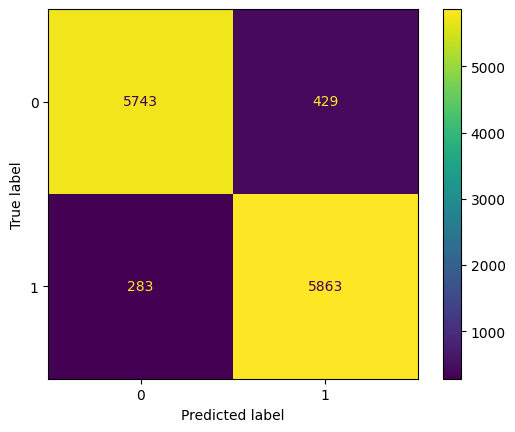

In [38]:
predictions = model.predict(np.array(X_test))
predictions = list(map(lambda x: 1 if (x > 0.5) else 0, predictions))

cm = confusion_matrix(y_test, predictions,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()

In [39]:
print(classification_report(y_test, list(predictions), digits=4))

              precision    recall  f1-score   support

           0     0.9530    0.9305    0.9416      6172
           1     0.9318    0.9540    0.9428      6146

    accuracy                         0.9422     12318
   macro avg     0.9424    0.9422    0.9422     12318
weighted avg     0.9424    0.9422    0.9422     12318



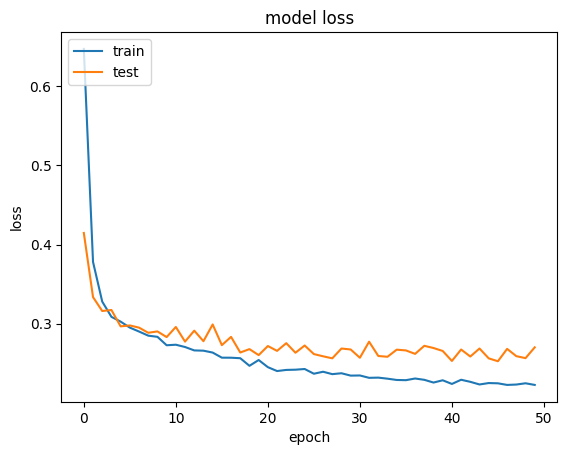

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()